In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/')
import config.system as sys_config

from helpers import data_bern_numpy_to_preprocessed_hdf5

In [2]:
basepath =  sys_config.project_data_root #"/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
savepath = sys_config.project_code_root + "data"

In [3]:
data_tr = data_bern_numpy_to_preprocessed_hdf5.load_masked_data(basepath, savepath, 0, 5, 'train')
masked_images_train = data_tr['masked_images_train']
masked_images_train.shape

Already preprocessed this configuration. Loading now...


(200, 144, 112, 48, 4)

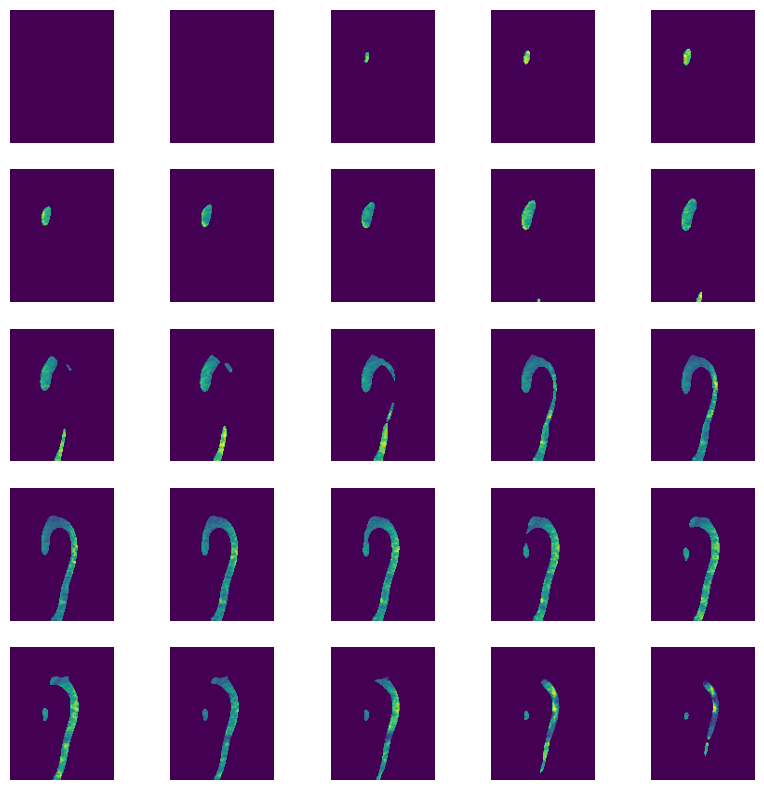

In [4]:

fig, axs = plt.subplots(5,5, figsize=(10,10))
ax = axs.ravel()
for i in range(25):
    ax[i].imshow(masked_images_train[(i+6), :,:, 20,0])
    #ax[i].set_title(i)
    ax[i].axis('off')

In [5]:
data_tr = data_bern_numpy_to_preprocessed_hdf5.load_cropped_data_sliced(basepath, savepath, 0, 5, 'train')
sliced_images_train = data_tr['sliced_images_train']
sliced_images_train.shape

Already preprocessed this configuration. Loading now...


(320, 32, 32, 48, 4)

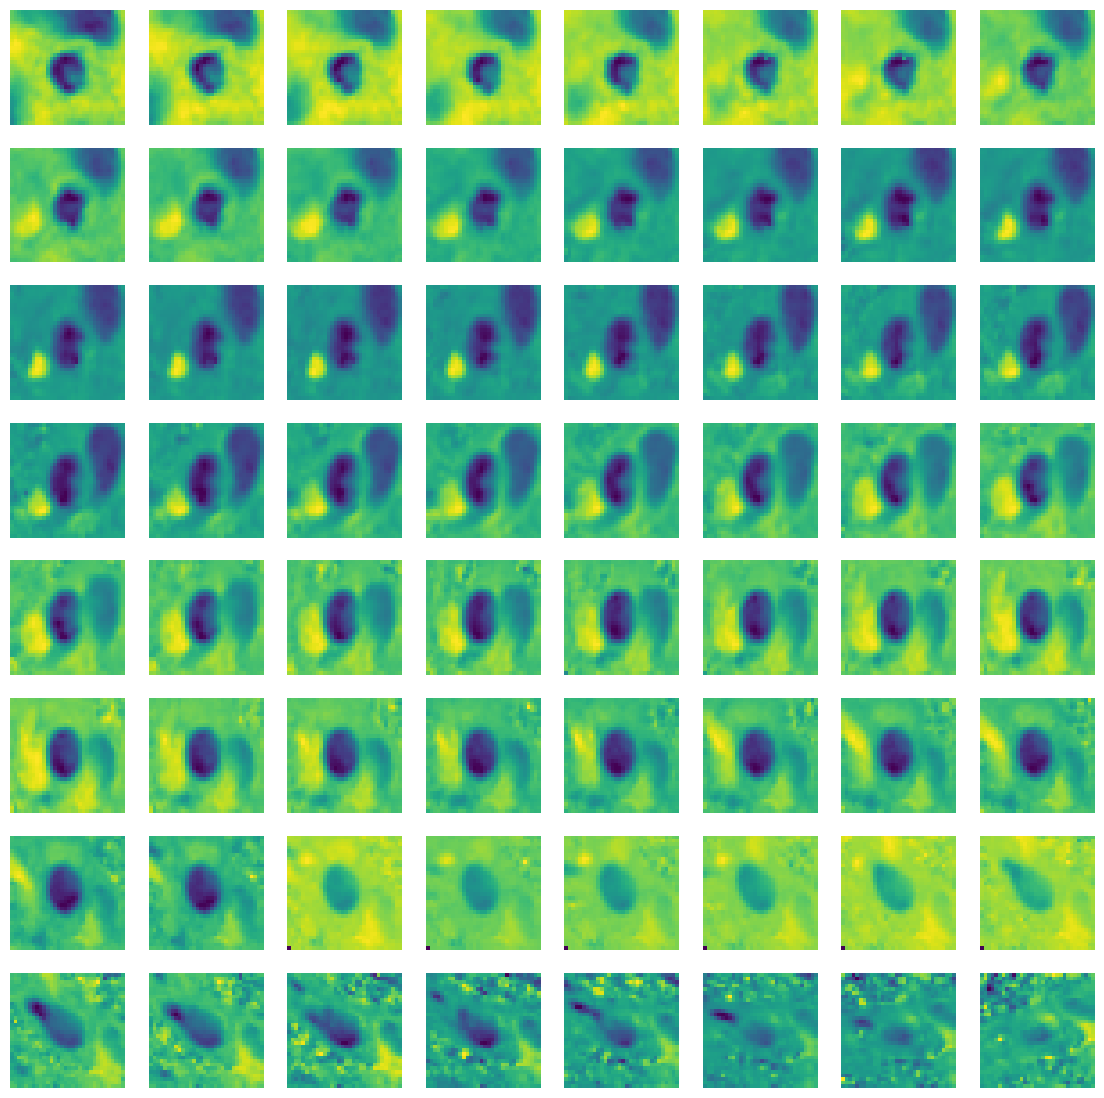

In [10]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(sliced_images_train[i+0, :,:,15,1])
    #ax[i].set_title(i)
    ax[i].axis('off')

In [3]:
data_tr = data_bern_numpy_to_preprocessed_hdf5.load_masked_data_sliced(basepath = basepath,
                                                                       savepath=savepath,

                                                        idx_start = 0,
                                                        idx_end = 5,
                                                        train_test='train', force_overwrite=True)
sliced_masked_images_train = data_tr['sliced_images_train']
sliced_masked_images_train.shape

This configuration has not yet been preprocessed.
Preprocessing now...
loading subject 1 out of 5...
patient: seg_MACDAVD_101_.npy
[[ 52  49  22]
 [ 52  50  22]
 [ 52  51  22]
 [ 53  47  21]
 [ 53  48  22]
 [ 53  52  22]
 [ 53  53  22]
 [ 53  55  23]
 [ 54  45  19]
 [ 54  46  20]
 [ 54  54  22]
 [ 54  56  23]
 [ 54  57  24]
 [ 54  58  25]
 [ 55  44  19]
 [ 55  59  24]
 [ 56  44  19]
 [ 56  60  25]
 [ 57  43  18]
 [ 57  61  25]
 [ 58  42  17]
 [ 58  62  25]
 [ 59  41  17]
 [ 59  63  25]
 [ 60  41  17]
 [ 60  63  25]
 [ 61  40  16]
 [ 61  64  25]
 [ 62  40  16]
 [ 62  65  26]
 [ 63  40  16]
 [ 63  65  26]
 [ 64  39  16]
 [ 64  66  25]
 [ 65  39  16]
 [ 65  66  25]
 [ 66  39  16]
 [ 66  67  25]
 [ 67  38  16]
 [ 67  67  25]
 [ 68  38  16]
 [ 68  68  26]
 [ 69  38  16]
 [ 69  68  25]
 [ 70  38  17]
 [ 70  68  25]
 [ 71  38  17]
 [ 71  68  25]
 [ 72  38  17]
 [ 72  68  25]
 [ 73  38  17]
 [ 73  69  26]
 [ 74  38  17]
 [ 74  69  26]
 [ 75  38  18]
 [ 75  69  26]
 [ 76  38  18]
 [ 76  69  26]

(320, 32, 32, 48, 4)

In [11]:
time_slice = 2
channel_slice = 1
masked_array = np.ma.masked_where(sliced_masked_images_train[:, :,:, time_slice,channel_slice] == 0, sliced_masked_images_train[:, :,:, time_slice,channel_slice])

(320, 32, 32)

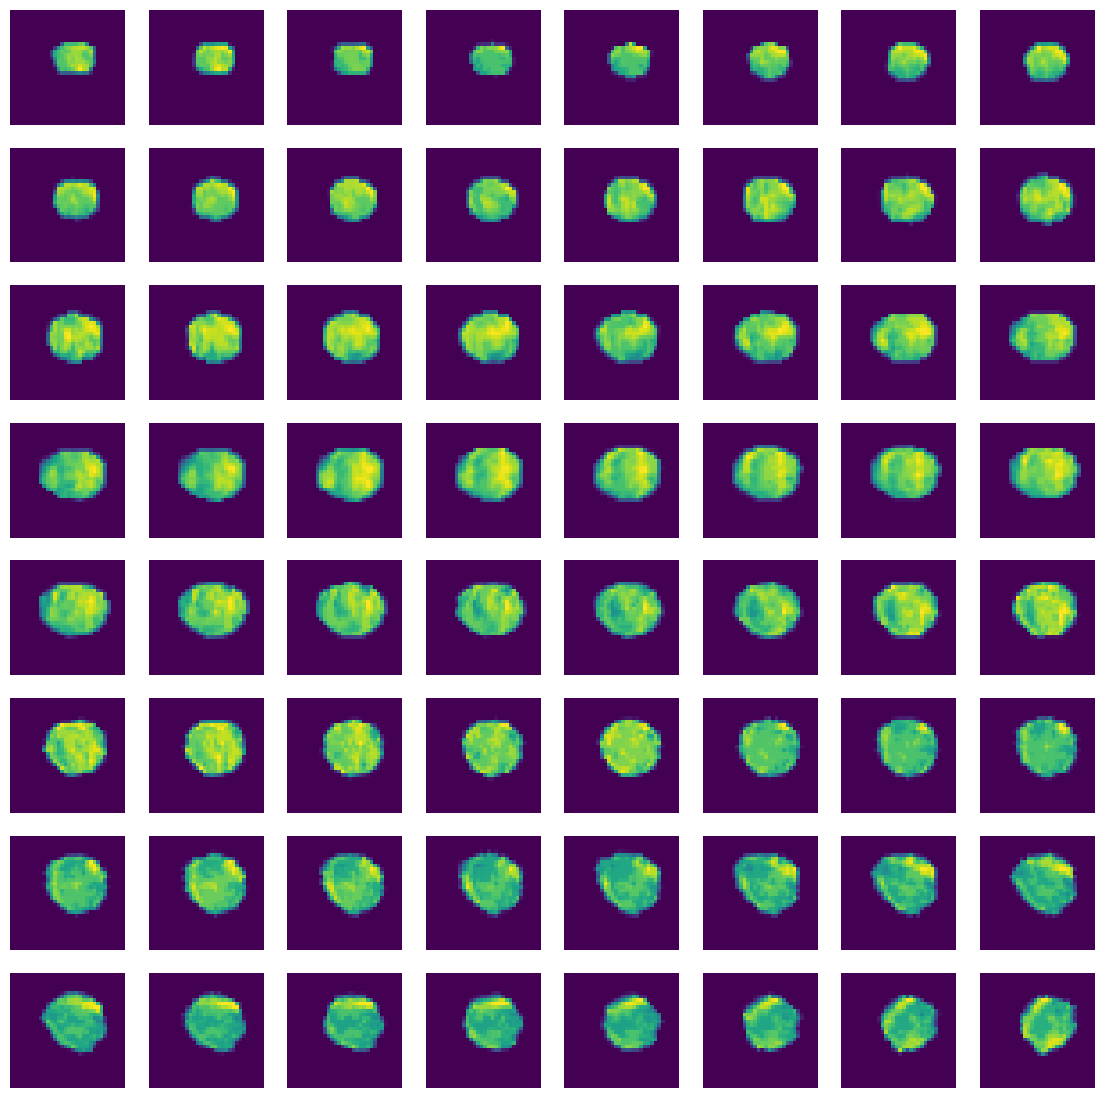

In [19]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(sliced_masked_images_train[i+0, :,:, 0,0])
    #ax[i].set_title(i)
    ax[i].axis('off')